In [1]:
import pandas as pd
import numpy as np

UQ_CSV = "predictions_uq_h24.csv"
PCOL = "p_exceed_cal"
T_EXCEED = 65.0
TAU = 0.40          # switch to 0.80 for emergency demo
WINDOW_HOURS = 14*24
STEP = 24           # slide by 1 day

df = pd.read_csv(UQ_CSV, parse_dates=["datetime"])
df = df[(df["split"] == "test")].copy()
df = df.sort_values(["city_id","datetime"])

# binary exceedance label
df["z_true"] = (df["y_true"] > T_EXCEED).astype(int)
df["alert"] = (df[PCOL] >= TAU).astype(int)

best = None  # (score, city_id, start_time, end_time)

for cid, g in df.groupby("city_id"):
    g = g.sort_values("datetime").reset_index(drop=True)
    if len(g) < WINDOW_HOURS:
        continue

    # require at least some exceedances in the whole test for that city
    if g["z_true"].sum() < 5:
        continue

    for start in range(0, len(g) - WINDOW_HOURS, STEP):
        w = g.iloc[start:start+WINDOW_HOURS]
        tp = ((w["alert"] == 1) & (w["z_true"] == 1)).sum()
        fp = ((w["alert"] == 1) & (w["z_true"] == 0)).sum()
        fn = ((w["alert"] == 0) & (w["z_true"] == 1)).sum()

        # simple storytelling score: reward TP, penalize FP and FN
        score = 3*tp - 1*fp - 2*fn

        if best is None or score > best[0]:
            best = (score, cid, w["datetime"].iloc[0], w["datetime"].iloc[-1])

print("BEST WINDOW:", best)

BEST WINDOW: (554, 1185262, Timestamp('2025-11-08 00:00:00'), Timestamp('2025-11-21 23:00:00'))


In [5]:
import pandas as pd
import numpy as np

UQ_CSV = "predictions_uq_h24.csv"
PCOL = "p_exceed_cal"
T_EXCEED = 65.0
TAU = 0.80          # switch to 0.80 for emergency demo
WINDOW_HOURS = 14*24
STEP = 24           # slide by 1 day

df = pd.read_csv(UQ_CSV, parse_dates=["datetime"])
df = df[(df["split"] == "test")].copy()
df = df.sort_values(["city_id","datetime"])

# binary exceedance label
df["z_true"] = (df["y_true"] > T_EXCEED).astype(int)
df["alert"] = (df[PCOL] >= TAU).astype(int)

best = None  # (score, city_id, start_time, end_time)

for cid, g in df.groupby("city_id"):
    g = g.sort_values("datetime").reset_index(drop=True)
    if len(g) < WINDOW_HOURS:
        continue

    # require at least some exceedances in the whole test for that city
    if g["z_true"].sum() < 5:
        continue

    for start in range(0, len(g) - WINDOW_HOURS, STEP):
        w = g.iloc[start:start+WINDOW_HOURS]
        tp = ((w["alert"] == 1) & (w["z_true"] == 1)).sum()
        fp = ((w["alert"] == 1) & (w["z_true"] == 0)).sum()
        fn = ((w["alert"] == 0) & (w["z_true"] == 1)).sum()

        # simple storytelling score: reward TP, penalize FP and FN
        score = 3*tp - 1*fp - 2*fn

        if best is None or score > best[0]:
            best = (score, cid, w["datetime"].iloc[0], w["datetime"].iloc[-1])

print("BEST WINDOW:", best)

BEST WINDOW: (40, 1185262, Timestamp('2025-11-08 00:00:00'), Timestamp('2025-11-21 23:00:00'))


Saved: fig_uq_timeline_bheramara.png


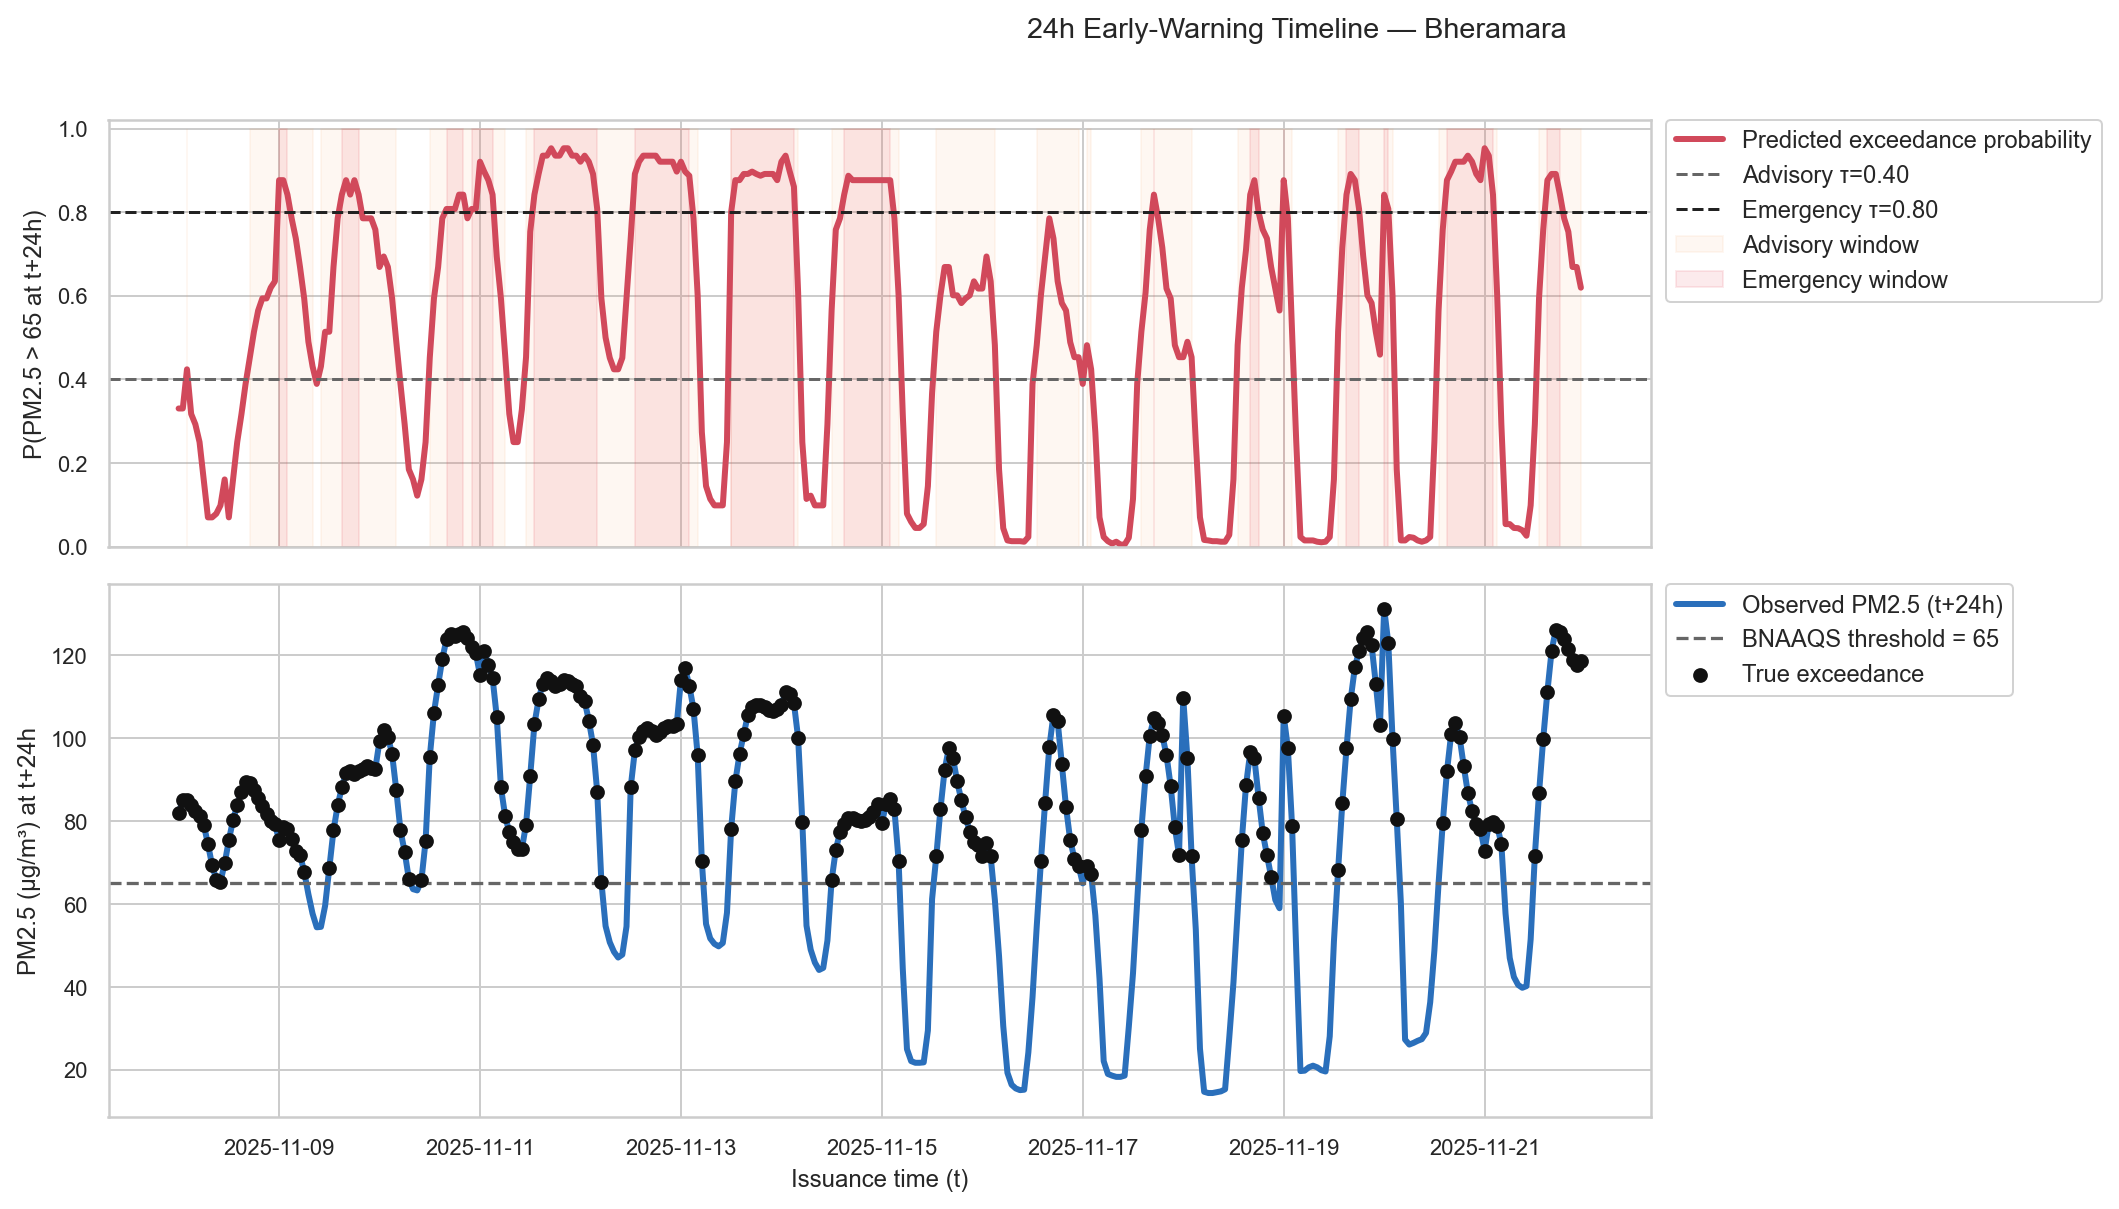

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_uq_timeline_2panel(
    uq_csv="predictions_uq_h24.csv",
    city_id=1185262,
    city_name="Bheramara",
    split="test",
    p_col="p_exceed_cal",
    t_exceed=65.0,
    tau_advisory=0.40,
    tau_emergency=0.80,
    start="2025-11-08 00:00:00",
    end="2025-11-21 23:00:00",
    out_png="fig_uq_timeline_bheramara.png"
):
    sns.set_theme(style="whitegrid", context="paper")
    df = pd.read_csv(uq_csv, parse_dates=["datetime"])
    df = df[(df["city_id"] == city_id) & (df["split"] == split)].copy()
    df = df.sort_values("datetime")

    df = df[(df["datetime"] >= pd.Timestamp(start)) & (df["datetime"] <= pd.Timestamp(end))].copy()
    if len(df) == 0:
        raise ValueError("No rows after filtering. Check city_id/split/start/end.")

    t = df["datetime"].to_numpy()
    y = df["y_true"].to_numpy(float)  # PM2.5 at (t+24h)
    p = np.clip(df[p_col].to_numpy(float), 0, 1)

    exceed = y > t_exceed
    adv = p >= tau_advisory
    emg = p >= tau_emergency

    fig, (axp, axy) = plt.subplots(
        2, 1, figsize=(14.5, 6.8), dpi=180, sharex=True,
        gridspec_kw={"height_ratios": [1, 1.25]}
    )

    # --- Probability panel ---
    axp.plot(t, p, linewidth=2.4, label="Predicted exceedance probability", color="#d1495b")
    axp.axhline(tau_advisory, linestyle="--", linewidth=1.2, label=f"Advisory τ={tau_advisory:.2f}", color="#666666")
    axp.axhline(tau_emergency, linestyle="--", linewidth=1.2, label=f"Emergency τ={tau_emergency:.2f}", color="#222222")
    axp.set_ylim(0, 1.02)
    axp.set_ylabel(f"P(PM2.5 > {t_exceed:g} at t+24h)")

    # shaded alert windows (lighter so it doesn't overpower)
    if adv.any():
        axp.fill_between(t, 0, 1, where=adv, step="pre", alpha=0.08, label="Advisory window", color="#f4a261")
    if emg.any():
        axp.fill_between(t, 0, 1, where=emg, step="pre", alpha=0.10, label="Emergency window", color="#e63946")

    # --- PM panel ---
    axy.plot(t, y, linewidth=2.4, label="Observed PM2.5 (t+24h)", color="#2a6fbb")
    axy.axhline(t_exceed, linestyle="--", linewidth=1.3, label=f"BNAAQS threshold = {t_exceed:g}", color="#666666")

    if exceed.any():
        axy.scatter(t[exceed], y[exceed], s=26, color="#111111", label="True exceedance", zorder=3)

    axy.set_ylabel("PM2.5 (µg/m³) at t+24h")
    axy.set_xlabel("Issuance time (t)")

    # ---- Legends: outside, not covering data ----
    leg1 = axp.legend(loc="upper left", bbox_to_anchor=(1.01, 1.00), borderaxespad=0.0, frameon=True, fontsize=9.5)
    leg1.get_frame().set_alpha(0.88)

    leg2 = axy.legend(loc="upper left", bbox_to_anchor=(1.01, 1.00), borderaxespad=0.0, frameon=True, fontsize=9.5)
    leg2.get_frame().set_alpha(0.88)

    fig.suptitle(f"24h Early-Warning Timeline — {city_name}", y=0.98)
    fig.tight_layout(rect=[0, 0, 0.82, 0.96])  # leave space on right for legends
    fig.savefig(out_png, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()

plot_uq_timeline_2panel()

In [9]:
import pandas as pd

IN_CSV  = "metrics_uq_h24.csv"
OUT_CSV = "metrics_uq_h24_test_cal_only.csv"

df = pd.read_csv(IN_CSV)

# Keep only TEST + calibrated probs + the two policy thresholds
keep = df[
    (df["split"] == "test") &
    (df["p_col"] == "p_exceed_cal") &
    (df["tau"].isin([0.4, 0.8]))
].copy()

# Select + rename columns for paper
keep = keep[[
    "split", "p_col", "tau",
    "brier", "ece", "auprc",
    "precision", "recall", "f1",
    "tp", "fp", "tn", "fn"
]].rename(columns={
    "p_col": "Probability",
    "tau": "Decision τ",
    "brier": "Brier↓",
    "ece": "ECE↓",
    "auprc": "AUPRC↑",
    "precision": "Precision",
    "recall": "Recall",
    "f1": "F1",
    "tp": "TP",
    "fp": "FP",
    "tn": "TN",
    "fn": "FN",
})

# Pretty labels
keep["split"] = keep["split"].str.upper()
keep["Probability"] = "Calibrated prob"

# Round for paper
num_cols = ["Brier↓","ECE↓","AUPRC↑","Precision","Recall","F1"]
keep[num_cols] = keep[num_cols].round(3)

# Sort τ ascending
keep = keep.sort_values("Decision τ").reset_index(drop=True)

# Save + display
keep.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)
display(keep)

Saved: metrics_uq_h24_test_cal_only.csv


,split,Probability,Decision τ,Brier↓,ECE↓,AUPRC↑,Precision,Recall,F1,TP,FP,TN,FN
0,TEST,Calibrated prob,0.4,0.047,0.011,0.658,0.676,0.579,0.624,5323,2553,89171,3873
1,TEST,Calibrated prob,0.8,0.047,0.011,0.658,0.845,0.135,0.233,1240,227,91497,7956



[TEST | p_exceed_cal | τ=0.40] TN=89171 FP=2553 FN=3873 TP=5323

[TEST | p_exceed_cal | τ=0.80] TN=91497 FP=227 FN=7956 TP=1240

Saved: fig_uq_confusion_matrices_test.png


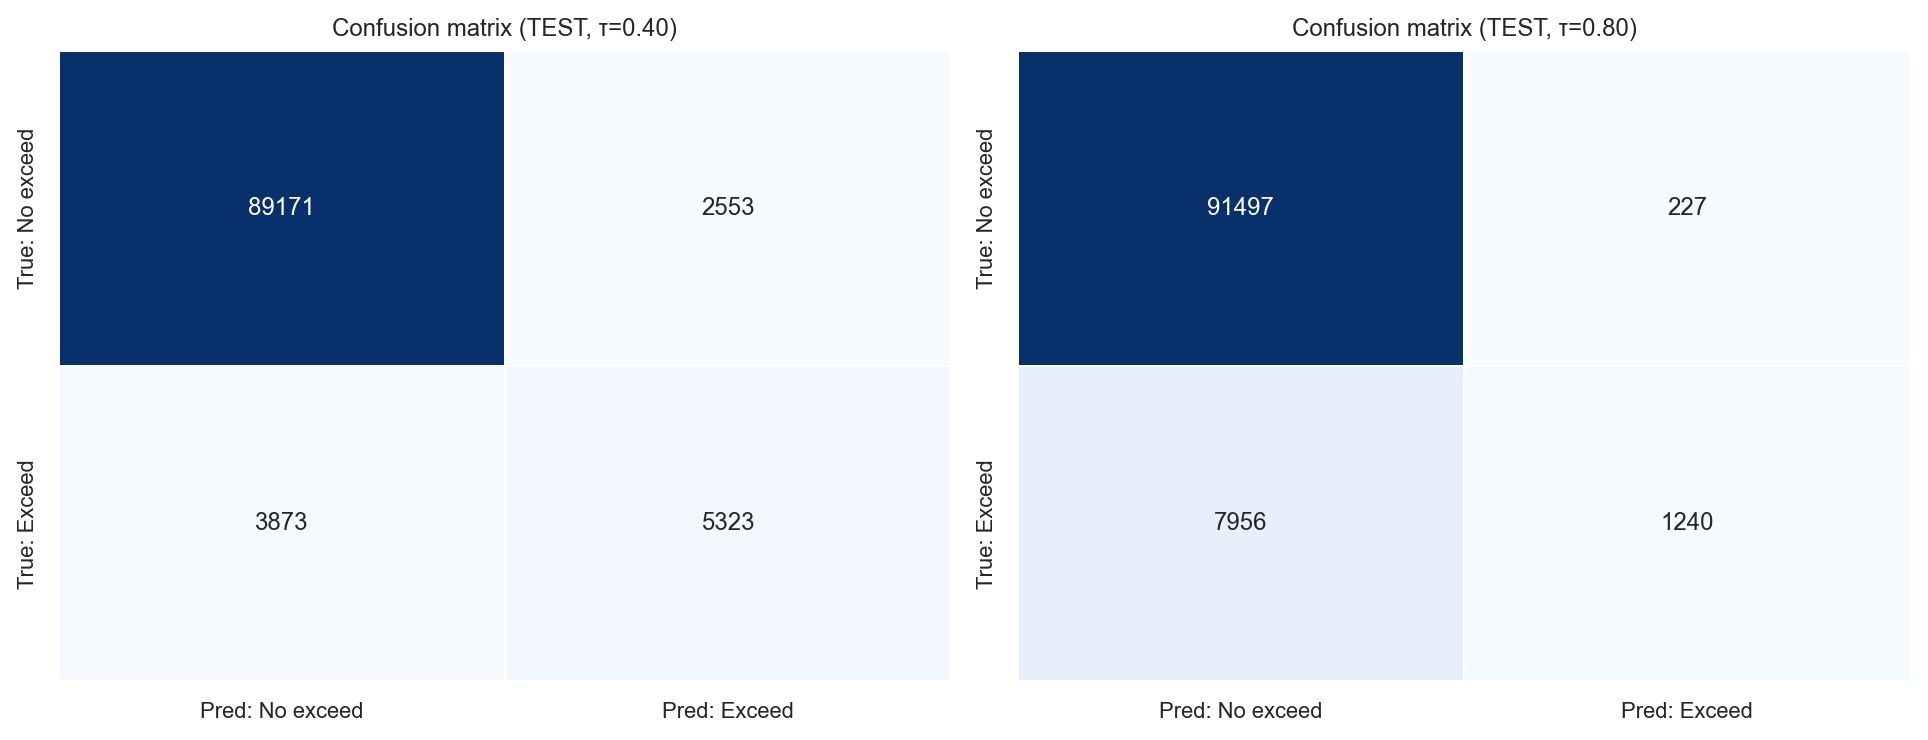

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

def plot_confusion_matrices_uq(
    uq_csv="predictions_uq_h24.csv",
    split="test",
    p_col="p_exceed_cal",
    t_exceed=65.0,
    taus=(0.40, 0.80),
    out_png="fig_uq_confusion_matrices_test.png"
):
    sns.set_theme(style="whitegrid", context="paper")

    df = pd.read_csv(uq_csv, parse_dates=["datetime"])
    df = df[df["split"] == split].copy()

    # Ground truth: exceedance event at t+24h
    y_true = (df["y_true"].values.astype(float) > t_exceed).astype(int)
    p = np.clip(df[p_col].values.astype(float), 0, 1)

    fig, axes = plt.subplots(1, len(taus), figsize=(10.8, 4.2), dpi=180)

    if len(taus) == 1:
        axes = [axes]

    for ax, tau in zip(axes, taus):
        y_hat = (p >= tau).astype(int)

        # sklearn returns [[TN, FP],[FN, TP]]
        cm = confusion_matrix(y_true, y_hat, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        # nicer labels
        cm_df = pd.DataFrame(
            cm,
            index=["True: No exceed", "True: Exceed"],
            columns=["Pred: No exceed", "Pred: Exceed"]
        )

        sns.heatmap(
            cm_df, annot=True, fmt="d", cmap="Blues",
            cbar=False, ax=ax, linewidths=0.6, linecolor="white"
        )

        ax.set_title(f"Confusion matrix ({split.upper()}, τ={tau:.2f})")
        ax.set_xlabel("")
        ax.set_ylabel("")

        print(f"\n[{split.upper()} | {p_col} | τ={tau:.2f}] TN={tn} FP={fp} FN={fn} TP={tp}")

    fig.tight_layout()
    fig.savefig(out_png, bbox_inches="tight")
    print("\nSaved:", out_png)
    plt.show()

plot_confusion_matrices_uq()